# PiNN model to generate a repulsive potential

Input: DFTB_DB.db DFTB_DB.db CCS_DB.db 

Output: PiNN model to be used in conjunction with DFTB+CCS calculations. 

In [1]:
import os, sys, warnings
import tensorflow as tf
from glob import glob
from collections import OrderedDict, defaultdict
from ase.collections import g2
import pinn
from pinn.io import load_ase, sparse_batch

#from pinn.models import potential_model
#from pinn.calculator import PiNN_calc
import warnings
warnings.filterwarnings('ignore')
# CPU is used for documentation generation, feel free to use your GPU!
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import ase.db
base_dir=os.getcwd()
os.chdir(base_dir)
print('Base dir:', base_dir)
sys.path.append('../pgm/python_scripts')
from rep_parautomatik import generate_pinndata

# We heavily use indexed slices to do sparse summations,
# which causes tensorflow to complain,
# we believe it's safe to ignore this warning.
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

2022-01-11 11:31:33.851280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/broqvist/PGM/rdkit-Release_2016_03_1/lib:/usr/local/cuda-9.2/lib64:/home/broqvist/PGM/rdkit-Release_2016_03_1/lib:/usr/local/cuda-9.2/lib64::/usr/local/cuda-9.2/lib64:/usr/local/cuda-9.2/lib64
2022-01-11 11:31:33.851310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Base dir: /home/broqvist/Desktop/parautomatik/EC


# Generate the dataset 
Here we use the newly generated ase databases (DFTB_DB and CCS_DB) together with the original DFT_DB to create the training set for the training of the machine learning potential. The outpout of this step is 

- trainset.xyz
- erep.dat
- trainset_urep.xyz
- erep_udftb.dat

Here we use a 80:20 test set. 

In [ ]:
# generate the data set 
os.chdir(base_dir)
if not os.path.isdir(base_dir+"/PiNN/"):
    os.mkdir(base_dir+"/PiNN/")

db_ccs=ase.db.connect("CCS_DB.db")     # CCS database
db_dft=ase.db.connect("DFT_DB.db")     # DFT database, original keys for structure
db_dftb=ase.db.connect("DFTB_DB.db")   # DFTB database  

os.chdir(base_dir+"/PiNN/")
generate_pinndata(db_dft,db_dftb,db_ccs)
os.chdir(base_dir)

In [2]:
os.chdir(base_dir)
os.chdir(base_dir+"/PiNN/")

from pinn.io import load_ase, write_tfrecord

filelist = 'trainset.xyz'
dataset = lambda: load_ase(filelist, splits={'train':8, 'test':2})
train = lambda: dataset()['train'].repeat().shuffle(1000).apply(sparse_batch(1))
test = lambda: dataset()['test'].apply(sparse_batch(1))
os.chdir(base_dir)

# Train PiNN 

In [3]:
os.chdir(base_dir)
#start tensorboard
##!kill 26028
%load_ext tensorboard
%tensorboard --logdir /home/broqvist/Desktop/parautomatik/EC/


In [4]:
from pinn import get_model
import ase.db as db
os.chdir(base_dir)
DFT_DB=db.connect("DFTB_DB.db")
elements=[]
for row in DFT_DB.select('1<id<10'):
    structure=row.toatoms()
    a=structure.get_atomic_numbers()
    for i in a: 
        if i not in elements:
            elements.append(i)
print(elements)
os.chdir(base_dir+"/PiNN/")

params={'model_dir': './',
          'network': {
              'name': 'PiNet',
              'params': {
                  'pp_nodes': [8,8],
                  'pi_nodes':[8,8],
                  'ii_nodes': [8,8],
                  'basis_type': 'gaussian',
                  'n_basis': 5,
                  'depth': 4,
                  'rc':4.0,
                  'atom_types':elements
              },
          },
          'model': {
              'name': 'potential_model',
              'params': {
                  'use_force': True, 
              }},
        'optimizer': {
    'class_name': 'EKF',
    'config': {
        'learning_rate': 0.001,
        'q_0': 0.000000,
        'q_min': 0.00000000,
    }}
}

from pinn.utils import init_params 
print(params) 
#init_params(params, train) #ds['train'])

model = get_model(params)

os.chdir(base_dir)

[6, 1, 8]
{'model_dir': './', 'network': {'name': 'PiNet', 'params': {'pp_nodes': [8, 8], 'pi_nodes': [8, 8], 'ii_nodes': [8, 8], 'basis_type': 'gaussian', 'n_basis': 5, 'depth': 4, 'rc': 4.0, 'atom_types': [6, 1, 8]}}, 'model': {'name': 'potential_model', 'params': {'use_force': True}}, 'optimizer': {'class_name': 'EKF', 'config': {'learning_rate': 0.001, 'q_0': 0.0, 'q_min': 0.0}}}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_cre

In [13]:
os.chdir(base_dir)
os.chdir(base_dir+"/PiNN/")
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=50000)
eval_spec = tf.estimator.EvalSpec(input_fn=test)
os.chdir(base_dir)

In [ ]:
os.chdir(base_dir)
os.chdir(base_dir+"/PiNN/")
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
os.chdir(base_dir)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
4600 trainable vaiabless, training with float32 precision.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into ./model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:loss = 0.17762345, step = 10000
INFO:tensorflow:global_step/se

IOStream.flush timed out


INFO:tensorflow:global_step/sec: 1.98135
INFO:tensorflow:loss = 2.2646966, step = 14900 (50.471 sec)
INFO:tensorflow:global_step/sec: 3.95983
INFO:tensorflow:loss = 0.5892699, step = 15000 (25.254 sec)
INFO:tensorflow:global_step/sec: 3.03969
INFO:tensorflow:loss = 0.92227274, step = 15100 (32.902 sec)
INFO:tensorflow:global_step/sec: 3.90388
INFO:tensorflow:loss = 0.43481776, step = 15200 (25.611 sec)
INFO:tensorflow:global_step/sec: 3.91999
INFO:tensorflow:loss = 0.15804137, step = 15300 (25.510 sec)
INFO:tensorflow:global_step/sec: 3.9664
INFO:tensorflow:loss = 0.618212, step = 15400 (25.214 sec)
INFO:tensorflow:global_step/sec: 3.86747
INFO:tensorflow:loss = 0.16183354, step = 15500 (25.857 sec)
INFO:tensorflow:global_step/sec: 3.87527
INFO:tensorflow:loss = 1.6526997, step = 15600 (25.803 sec)


# Analysis of potential and data

Search for outliers and problematic data points. 

In [8]:
import warnings
warnings.filterwarnings('ignore')
def evalsth(model,test):
    from pinn.io import load_tfrecord, sparse_batch
    from pinn import get_model
    import numpy as np
    ds = lambda: dataset()['test'].apply(sparse_batch(1))
    #ds = lambda: load_tfrecord(f'../DFTB-EuOZn/{name}/train.yml').apply(sparse_batch(1))
    natoms = np.array([len(dat['elems']) for dat in ds().as_numpy_iterator()])
    labels = [dat['e_data'][0] for dat in ds().as_numpy_iterator()]
    preds = [pred['energy'] for pred in model.predict(ds)]
    errors = np.array(labels) - preds
    return errors, np.array(preds)/natoms, np.array(labels)/natoms, ds

def get_struct(ds, idx):
    from ase import Atoms
    for i, dat in enumerate(ds().as_numpy_iterator()):
        if idx==i:
            return Atoms(dat['elems'], positions=dat['coord'], cell=dat['cell'][0])

In [9]:
os.chdir(base_dir)
os.chdir(base_dir+"/PiNN/")

error, pred, label, ds = evalsth(model,test)
os.chdir(base_dir)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[1.9692128 1.9842427 2.0959153 2.2677197 2.4487443 3.093391  3.3504305
 4.4604    5.502864  5.6152554]
max= 191


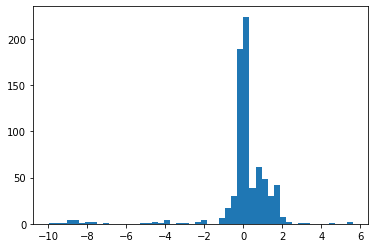

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


plt.hist(error, 50)
print(np.sort(error)[-10:])
stm=np.argmax(error)


print('max=',stm)

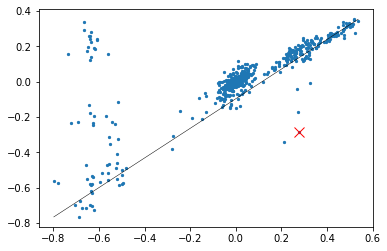

In [11]:
plt.plot([np.min(label),np.max(label)], [np.min(pred),np.max(pred)], 'k-', lw=0.5)

plt.scatter(label, pred, s=5)
plt.plot(label[stm], pred[stm], 'rx', ms=10)
#plt.xlim(99.5,102)
#plt.ylim(99.5,102)



In [12]:
from ase.visualize import view
atoms = get_struct(ds, stm)


view(atoms)

FileNotFoundError: [Errno 2] No such file or directory: 'trainset.xyz'